In [1]:
import numpy as np
import pandas as pd
import re
import csv
import numpy as np
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.merge import concatenate,subtract


import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import tensorflow as tf


from nltk.corpus import stopwords

from string import punctuation

from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.layers import add


seed = 1
np.random.seed(seed)
import warnings
import sys
if not sys.warnoptions:

    warnings.simplefilter("ignore")


Using TensorFlow backend.


In [2]:
# Reading the FNC data
train_head = pd.read_csv('data/train_stances.csv')

train_body = pd.read_csv('data/train_bodies.csv')

test_head = pd.read_csv('data/competition_test_stances.csv')

test_body = pd.read_csv('data/competition_test_bodies.csv')

In [3]:
# Converting the stances to numbers
train_head.replace('unrelated',0,True)
train_head.replace('agree',1,True)
train_head.replace('disagree',2,True)
train_head.replace('discuss',3,True)

test_head.replace('unrelated',0,True)
test_head.replace('agree',1,True)
test_head.replace('disagree',2,True)
test_head.replace('discuss',3,True)

In [4]:
# Categorizing the labels in 2 classes: Unrelated and Related

def labels(row):
    
    if row['Stance'] == 0:
        
      return 1

    else:
        
      return 0

train_head['Modified Labels'] = train_head.apply(labels, axis=1)

In [5]:
train_head.head()

,Headline,Body ID,Stance,Modified Labels
0,Police find mass graves with at least '15 bodi...,712,0,1
1,Hundreds of Palestinians flee floods in Gaza a...,158,1,0
2,"Christian Bale passes on role of Steve Jobs, a...",137,0,1
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,0,1
4,Spider burrowed through tourist's stomach and ...,1923,2,0


In [6]:
info = train_head[['Modified Labels']]

In [7]:
info.describe()

,Modified Labels
count,49972.000000
mean,0.731310
std,0.443283
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [8]:
train = train_head.join(train_body.set_index('Body ID'), on = 'Body ID')

train.head()

,Headline,Body ID,Stance,Modified Labels,articleBody
0,Police find mass graves with at least '15 bodi...,712,0,1,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,1,0,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,0,1,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,0,1,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1923,2,0,"Fear not arachnophobes, the story of Bunbury's..."


In [9]:
test = test_head.join(test_body.set_index('Body ID'), on='Body ID')

test.head()

,Headline,Body ID,Stance,articleBody
0,Ferguson riots: Pregnant woman loses eye after...,2008,0,A RESPECTED senior French police officer inves...
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,0,Dave Morin's social networking company Path is...
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,0,A bereaved Afghan mother took revenge on the T...
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,0,Hewlett-Packard is officially splitting in two...
4,Argentina's President Adopts Boy to End Werewo...,37,0,An airline passenger headed to Dallas was remo...


In [10]:
# For training and test data
train_head_seq = [text_to_word_sequence(head) for head in train['Headline']]
train_body_seq = [text_to_word_sequence(body) for body in train['articleBody']]

test_head_seq = [text_to_word_sequence(head) for head in test['Headline']]
test_body_seq = [text_to_word_sequence(body) for body in test['articleBody']]

In [11]:
# For original data: List necessary to create the training vocabulary
# Appending all words from headings and articleBody in the train data to the list_words
list_words = []

for i in range(len(train_head_seq)):
    
    list_words.append(train_head_seq[i])

print(len(list_words))

for i in range(len(train_body_seq)):
    
    list_words.append(train_body_seq[i])
    
print(len(list_words))

49972
99944


In [12]:
symbols = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer(num_words= 30000, filters = symbols)

tokenizer.fit_on_texts([word for word in list_words])

print("Size of Vocabulary:", len(tokenizer.word_index))

Size of Vocabulary: 27873


In [13]:
# Training Original data: Vectorization

X_head_train = tokenizer.texts_to_sequences([' '.join(seq[: 15]) for seq in train_head_seq])

X_head_train = pad_sequences(X_head_train, maxlen = 15, padding = 'post', truncating = 'post')



X_body_train = tokenizer.texts_to_sequences([' '.join(seq[: 300]) for seq in train_body_seq])

X_body_train = pad_sequences(X_body_train, maxlen = 300, padding = 'post', truncating = 'post')


y_stance_train = train['Stance']

y_classify_train = train['Modified Labels']

In [14]:
# Test Data: Vectorization

X_head_test = tokenizer.texts_to_sequences([' '.join(seq[: 15]) for seq in test_head_seq])

X_head_test = pad_sequences(X_head_test, maxlen = 15, padding = 'post', truncating = 'post')

X_body_test = tokenizer.texts_to_sequences([' '.join(seq[: 300]) for seq in test_body_seq])

X_body_test = pad_sequences(X_body_test, maxlen = 300, padding = 'post', truncating = 'post')

In [15]:
#Encode class values as integers

encoder_train_stance = LabelEncoder()

encoder_train_stance.fit(y_stance_train)                         # The actual stances: 0,1,2,3

encoded_train = encoder_train_stance.transform(y_stance_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train_stance = np_utils.to_categorical(encoded_train)



#Classify encoding

encoder_train_label = LabelEncoder()     

encoder_train_label.fit(y_classify_train)                      # The modified labels: 0,1

encoded_train_label = encoder_train_label.transform(y_classify_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train_label = np_utils.to_categorical(encoded_train_label)

In [16]:
test = test_head.join(test_body.set_index('Body ID'), on = 'Body ID')

test.head()

test_head_seq = [text_to_word_sequence(head) for head in test['Headline']]

test_body_seq = [text_to_word_sequence(body) for body in test['articleBody']]

    
X_head_test = tokenizer.texts_to_sequences([' '.join(seq[: 50]) for seq in test_head_seq])

X_head_test = pad_sequences(X_head_test, maxlen = 50, padding = 'post', truncating = 'post')

X_body_test = tokenizer.texts_to_sequences([' '.join(seq[: 300]) for seq in test_head_seq])

X_body_test = pad_sequences(X_body_test, maxlen = 300, padding = 'post', truncating = 'post')

y_test = test['Stance']

In [17]:
# Word embedings: Fasttext:

embeddings = KeyedVectors.load_word2vec_format('data/fasttext/wiki-news-300d-1M.vec')

embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, 300)) 

for word, i in tokenizer.word_index.items(): 
    
  try:
    
      embeddings_vector = embeddings[word]
        
  except KeyError:
    
      embeddings_vector = None
        
  if embeddings_vector is not None:
    
      embeddings_matrix[i] = embeddings_vector

del embeddings

In [18]:

# Build a sequential model by stacking neural net units 

left = Sequential()

left.add(Embedding(input_dim = len(tokenizer.word_index)+1,
                          output_dim = 300,
                          weights = [embeddings_matrix], trainable=False, mask_zero=True))

left.add(Bidirectional(LSTM(100, return_sequences=False)))


right = Sequential()

right.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim= 300,
                          weights = [embeddings_matrix], trainable=False, mask_zero=True))

right.add(Bidirectional(LSTM(100, return_sequences = False)))


concatenated = concatenate([left.output,right.output])

layer_1 = Dense(100, activation = 'relu') (concatenated)

dropout_1 = Dropout(rate = 0.5)(layer_1)

layer_2 =Dense(50,  activation='relu') (dropout_1)

dropout_2 = Dropout(rate = 0.5)(layer_2)


out1 = Dense(4, activation = 'softmax')(dropout_2)

model = Model([left.input, right.input], out1)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  (None, None)         0                                            
__________________________________________________________________________________________________
embedding_2_input (InputLayer)  (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    8362200     embedding_1_input[0][0]          
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 300)    8362200     embedding_2_input[0][0]          
____________________________________________________________________________________________

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.save('models/Bidirectional_LSTM_Concat.h5')

In [20]:
history = model.fit([X_head_train,X_body_train], y = dummy_y_train_stance, 
          batch_size = 128,
          epochs = 5,
          verbose = 1,
          validation_split = 0.1)

Train on 44974 samples, validate on 4998 samples
Epoch 1/5
44974/44974 [==============================] - 741s 16ms/step - loss: 0.7582 - accuracy: 0.7394 - val_loss: 0.5438 - val_accuracy: 0.7883
Epoch 2/5
44974/44974 [==============================] - 730s 16ms/step - loss: 0.5135 - accuracy: 0.7974 - val_loss: 0.4243 - val_accuracy: 0.8353
Epoch 3/5
44974/44974 [==============================] - 727s 16ms/step - loss: 0.3943 - accuracy: 0.8469 - val_loss: 0.3130 - val_accuracy: 0.8834
Epoch 4/5
44974/44974 [==============================] - 726s 16ms/step - loss: 0.3056 - accuracy: 0.8830 - val_loss: 0.2756 - val_accuracy: 0.8958
Epoch 5/5
44974/44974 [==============================] - 730s 16ms/step - loss: 0.2506 - accuracy: 0.9071 - val_loss: 0.2337 - val_accuracy: 0.9110


In [21]:
import pickle

with open('FNC_BiLSTM_Concat.pickle', 'wb') as f:
    
    pickle.dump(history, f)

In [22]:
with open('FNC_BiLSTM_Concat.pickle', 'rb') as f:
    
    history = pickle.load(f)

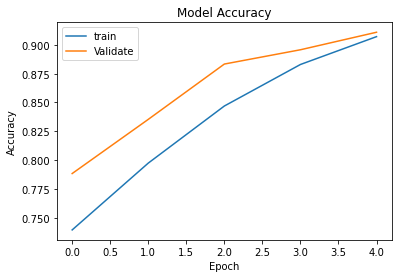

In [23]:
# Accuracy Plot

plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epoch')

plt.legend(['train', 'Validate'])

plt.show()

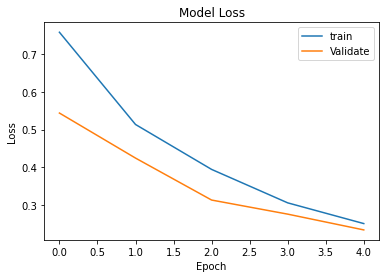

In [24]:
# Loss Plot

plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('Model Loss')

plt.ylabel('Loss')

plt.xlabel('Epoch')

plt.legend(['train', 'Validate'])

plt.show()

In [25]:
# Predict the stances for the test data

pred = model.predict([X_head_test, X_body_test])

In [26]:
predicted_labels = [np.argmax(p, axis = -1) for p in pred]

In [27]:
True_labels = y_test

In [28]:
# Convert the stances to the text stances

for i in range(len(predicted_labels)):

    if predicted_labels[i] == 0: predicted_labels[i] = "unrelated"

    if predicted_labels[i] == 1: predicted_labels[i] = "agree"

    if predicted_labels[i] == 2: predicted_labels[i] = "disagree"

    if predicted_labels[i] == 3: predicted_labels[i] = "discuss"

for i in range(len(True_labels)):

    if True_labels[i] == 0: True_labels[i] = "unrelated"

    if True_labels[i] == 1: True_labels[i] = "agree"

    if True_labels[i] == 2: True_labels[i] = "disagree"

    if True_labels[i] == 3: True_labels[i] = "discuss"

In [29]:
test_df = pd.read_csv('data/competition_test_stances.csv')

In [30]:
# Replacing the original stance labels with the predicted labels

pred_stance = predicted_labels

bodyid = []

headline = []

for i in range(len(test_df.Stance)):

    bodyid.append(test_df['Body ID'][i])

    headline.append(test_df['Headline'][i])

In [31]:
df_submit = pd.DataFrame( data = {'Headline': headline, 'Body ID': bodyid, "Stance": pred_stance})

In [32]:
df_submit.to_csv('answer_Bi-LSTM_Concat_Final.csv', index = False, encoding = 'utf-8')

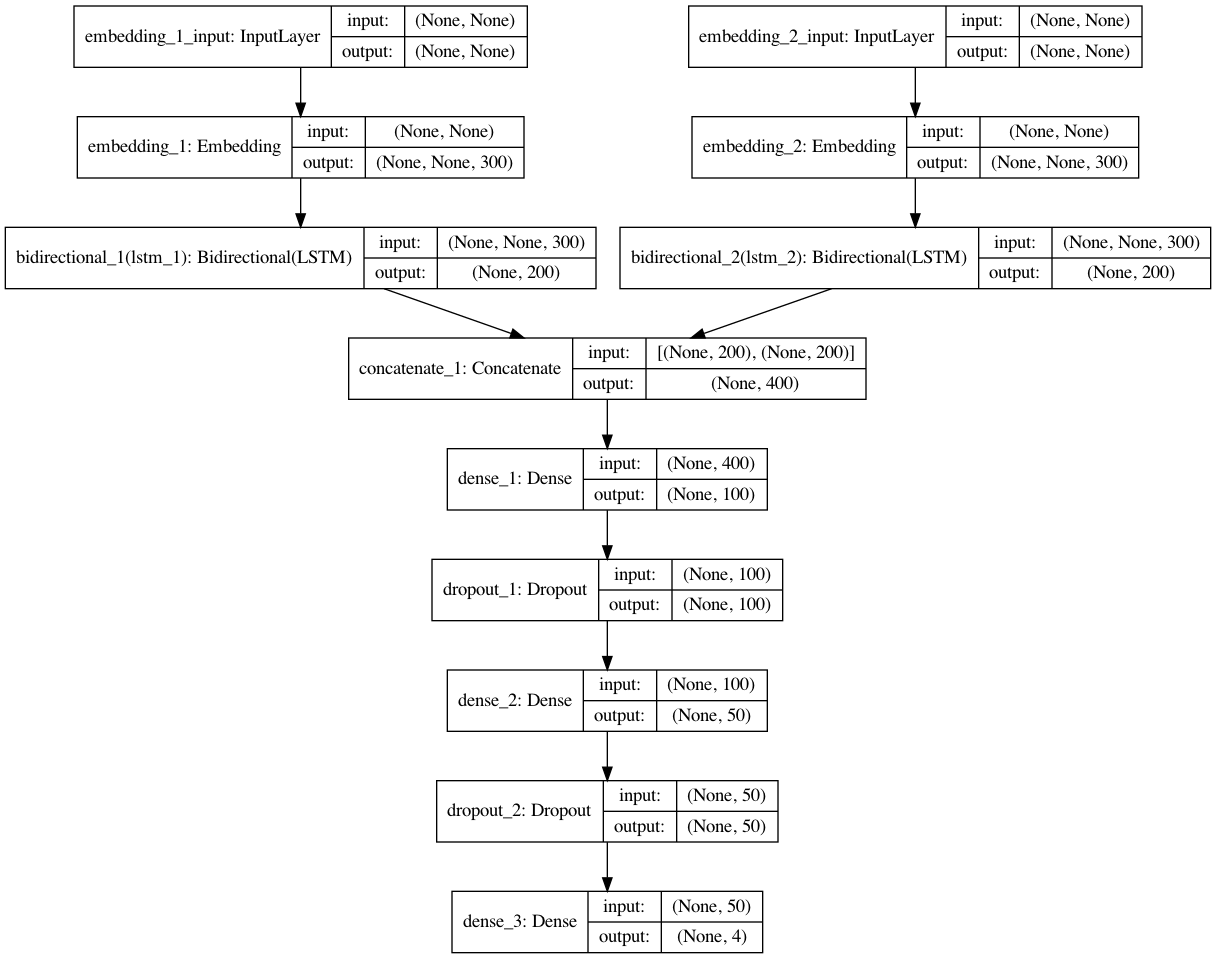

In [33]:
plot_model(model, to_file='model_plot.png', show_shapes = True, show_layer_names = True)